In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
octane = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\cleaned_octane_database.csv')
comb_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\comb_heat.csv')
boil_p = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\boiling_point.csv')
densit = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\density.csv')
entr_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\raw_data\entropy_heat_capacity.csv')
auto_t = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\autoignition_temp.csv')

comb_h = comb_h.rename(columns={'Smiles':'SMILES'})
boil_p = boil_p.rename(columns={'Smiles':'SMILES'})
densit = densit.rename(columns={'Smiles':'SMILES'})

print(densit.shape)

(543, 4)


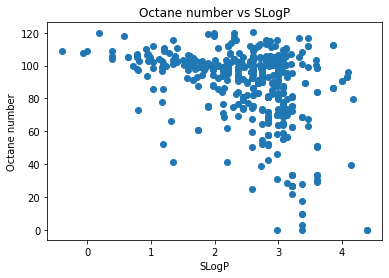

In [33]:
plt.scatter(octane['SLogP'],octane['y'])
plt.xlabel('SLogP')
plt.ylabel('Octane number') 
plt.title('Octane number vs SLogP')
plt.show()

In [35]:
comb_h.head(2)

,SMILES,?Hc°(KJ/kg)
0,C#CC(C)(C)C#C,40674.60867
1,C#CC(C)(C)CC,43242.50963


In [36]:
octane.head(2)

,Unnamed: 0,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,...,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice
0,0,CCCCO,1-Butanol,98.0,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,...,4.938211,20,2,14.0,12.0,2.75,1.5,0.0,98.0,abs dev < 0.01
1,1,CCO,Ethanol,109.0,702,"Sandia, UML",[6],ETHANOL,109.0,Training,...,5.115763,4,0,6.0,4.0,2.25,1.0,0.0,109.0,abs dev < 0.01


In [49]:
for df,name in zip([comb_h,boil_p,densit,entr_h,auto_t],['combustion heat','boiling point','density','entropy','autoig. temp']):
    print('Number of missing values for ' + name +' = {}'.format(pd.merge(octane,df,how='left',on='SMILES').iloc[:,-1].isnull().sum()))


Number of missing values for combustion heat = 443
Number of missing values for boiling point = 443
Number of missing values for density = 509
Number of missing values for entropy = 403
Number of missing values for autoig. temp = 396


In [55]:
len(set(octane['SMILES'].values)-set(comb_h['SMILES'].values))

443

In [56]:
octane.shape

(492, 892)